# Addition Task Training Notebook

This notebook trains a small transformer from scratch to perform k=4 digit addition.

## Task Format

- Input: `"1234 + 5678 ="`
- Output: `"6912"`

## Evaluation

- In-distribution (ID): Same format as training
- Out-of-distribution (OOD): `"1 234 + 5 678="` → accepts `"6912"` or `"6 912"` (any spacing)


## 1. Setup and Installation


In [1]:
# Install dependencies
!pip install -q torch transformers datasets trl wandb hydra-core matplotlib seaborn pandas

# Check GPU
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )


CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [2]:
import sys
import os
import shutil

# Remove existing src directory if it exists
if os.path.exists("src"):
    shutil.rmtree("src")

# Create fresh src directory
os.makedirs("src")

from google.colab import files
uploaded = files.upload(target_dir="src")

Saving tokenizer.py to src/tokenizer.py
Saving dataset.py to src/dataset.py
Saving huggingface_callbacks.py to src/huggingface_callbacks.py
Saving helpers.py to src/helpers.py


## 2. Task Setup Documentation


In [3]:
# Task configuration
task_setup = {
    "task": "Addition of two k-digit numbers",
    "k": 4,
    "input_format": "1234 + 5678 =",
    "output_format": "6912",
    "model_architecture": {
        "num_layers": 4,
        "hidden_size": 128,
        "num_attention_heads": 4,
        "intermediate_size": 512,
        "vocab_size": 13,  # 0-9, +, =, space
    },
    "tokenizer": {
        "type": "character-level",
        "vocab_size": 13,
        "tokens": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "+", "=", " "],
    },
}

print("Task Setup:")
print(f"  Task: {task_setup['task']}")
print(f"  k: {task_setup['k']}")
print(f"  Format: {task_setup['input_format']} → {task_setup['output_format']}")
print(f"  Model: {task_setup['model_architecture']}")
print(
    f"  Tokenizer: {task_setup['tokenizer']['type']} with {task_setup['tokenizer']['vocab_size']} tokens"
)


Task Setup:
  Task: Addition of two k-digit numbers
  k: 4
  Format: 1234 + 5678 = → 6912
  Model: {'num_layers': 4, 'hidden_size': 128, 'num_attention_heads': 4, 'intermediate_size': 512, 'vocab_size': 13}
  Tokenizer: character-level with 13 tokens


## 3. Data Generation and Diagnostics


In [4]:
# Import necessary modules
import random
import numpy as np
from datasets import Dataset

from src.tokenizer import CharTokenizer
from src.dataset import FinetuningDataset, get_datasets

# Initialize tokenizer
tokenizer = CharTokenizer()
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Sample encode: {tokenizer.encode('1234 + 5678 =')}")
print(f"Sample decode: {tokenizer.decode([1, 2, 3, 4, 12, 10, 12, 5, 6, 7, 8, 12, 11])}")


Tokenizer vocab size: 13
Sample encode: [1, 2, 3, 4, 12, 10, 12, 5, 6, 7, 8, 12, 11]
Sample decode: 1234 + 5678 =


In [5]:
# Generate datasets
seed = 1
k = 4
train_size = 50000
val_size = 10000  # Match test size for better balance
test_id_size = 10000
test_ood_size = 10000

dataset = FinetuningDataset(
    seed=seed,
    tokenizer=tokenizer,
    apply_chat_template=False,
    k=k,
    train_size=train_size,
    val_size=val_size,
    test_id_size=test_id_size,
    test_ood_size=test_ood_size,
)

train_dataset, val_dataset, test_id_dataset = dataset.generate_data()

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test ID size: {len(test_id_dataset)}")

# Show samples
print("\nSample training examples:")
for i in range(3):
    ex = train_dataset[i]
    print(f"  {ex['prompt']} → {ex['completion']}")


Train size: 50000
Val size: 10000
Test ID size: 10000

Sample training examples:
  2323 + 6877 = → 9200
  2575 + 2040 = → 4615
  4235 + 9387 = → 13622


In [6]:
# Verify no overlap between splits
train_pairs = {(ex["a"], ex["b"]) for ex in train_dataset}
val_pairs = {(ex["a"], ex["b"]) for ex in val_dataset}
test_pairs = {(ex["a"], ex["b"]) for ex in test_id_dataset}

overlap_train_val = len(train_pairs & val_pairs)
overlap_train_test = len(train_pairs & test_pairs)
overlap_val_test = len(val_pairs & test_pairs)

print(f"Overlap train-val: {overlap_train_val} (should be 0)")
print(f"Overlap train-test: {overlap_train_test} (should be 0)")
print(f"Overlap val-test: {overlap_val_test} (should be 0)")

data_diagnostics = {
    "train_size": len(train_dataset),
    "val_size": len(val_dataset),
    "test_id_size": len(test_id_dataset),
    "overlap_train_val": overlap_train_val,
    "overlap_train_test": overlap_train_test,
    "overlap_val_test": overlap_val_test,
}


Overlap train-val: 0 (should be 0)
Overlap train-test: 0 (should be 0)
Overlap val-test: 0 (should be 0)


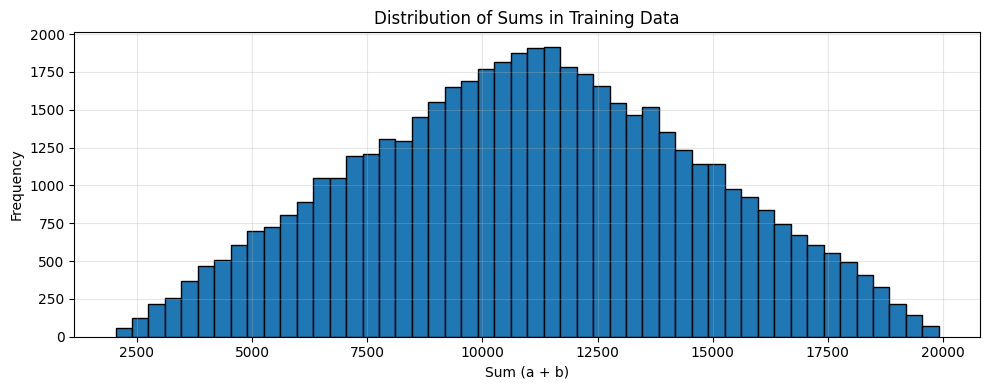

Sum range: 2036 to 19909
Mean sum: 11027.06
Std sum: 3690.44


In [7]:
# Plot distribution of sums
import matplotlib.pyplot as plt

train_sums = [ex["result"] for ex in train_dataset]

plt.figure(figsize=(10, 4))
plt.hist(train_sums, bins=50, edgecolor="black")
plt.xlabel("Sum (a + b)")
plt.ylabel("Frequency")
plt.title("Distribution of Sums in Training Data")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("sum_distribution.png", dpi=150)
plt.show()

print(f"Sum range: {min(train_sums)} to {max(train_sums)}")
print(f"Mean sum: {np.mean(train_sums):.2f}")
print(f"Std sum: {np.std(train_sums):.2f}")


## 4. Training Execution


In [8]:
# Training configuration
import time
import wandb
from transformers import AutoConfig, AutoModelForCausalLM
from trl import SFTConfig, SFTTrainer

# Hyperparameters
training_config = {
    "batch_size": 64,  # Batch size per GPU (64 examples per training step)
    "learning_rate": 5e-4,
    "num_epochs": 10,
    "gradient_accumulation_steps": 1,
    "warmup_ratio": 0.0,
    "weight_decay": 0.0,
    "max_grad_norm": 1.0,
}

model_config = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "num_attention_heads": 4,
    "intermediate_size": 512,
    "vocab_size": len(tokenizer),
}

print("Training Configuration:")
print(f"  Batch size: {training_config['batch_size']}")
print(f"  Learning rate: {training_config['learning_rate']}")
print(f"  Epochs: {training_config['num_epochs']}")
print(f"\nModel Configuration:")
for k, v in model_config.items():
    print(f"  {k}: {v}")

# Track GPU info
if torch.cuda.is_available():
    gpu_info = {
        "device": torch.cuda.get_device_name(0),
        "memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
    }
    print(f"\nGPU: {gpu_info['device']}")
    print(f"GPU Memory: {gpu_info['memory_gb']:.2f} GB")
else:
    gpu_info = None


Training Configuration:
  Batch size: 64
  Learning rate: 0.0005
  Epochs: 10

Model Configuration:
  num_hidden_layers: 4
  hidden_size: 128
  num_attention_heads: 4
  intermediate_size: 512
  vocab_size: 13

GPU: Tesla T4
GPU Memory: 15.83 GB


In [9]:
# Initialize wandb (optional - comment out if not using)
# wandb.login()
# wandb.init(
#     project="addition-task",
#     config={**training_config, **model_config}
# )


In [10]:
# Create model from scratch
config = AutoConfig.from_pretrained("gpt2")
config.num_hidden_layers = model_config["num_hidden_layers"]
config.hidden_size = model_config["hidden_size"]
config.num_attention_heads = model_config["num_attention_heads"]
config.intermediate_size = model_config["intermediate_size"]
config.vocab_size = model_config["vocab_size"]

model = AutoModelForCausalLM.from_config(config)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(
    f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model created with 926080 parameters
Trainable parameters: 926080


In [11]:
# Setup training arguments
output_dir = "./checkpoints"
os.makedirs(output_dir, exist_ok=True)

effective_batch_size = (
    training_config["batch_size"] * training_config["gradient_accumulation_steps"]
)
steps_per_epoch = len(train_dataset) // effective_batch_size
total_steps = steps_per_epoch * training_config["num_epochs"]

training_args = SFTConfig(
    output_dir=output_dir,
    report_to="wandb" if wandb.run else None,
    logging_strategy="steps",
    logging_steps=max(1, steps_per_epoch // 10),
    num_train_epochs=training_config["num_epochs"],
    completion_only_loss=True,
    per_device_train_batch_size=training_config["batch_size"],
    per_device_eval_batch_size=training_config["batch_size"],
    save_steps=max(1, steps_per_epoch // 5),
    save_strategy="steps",
    save_total_limit=5,
    eval_steps=max(1, steps_per_epoch // 5),
    eval_strategy="steps",
    gradient_accumulation_steps=training_config["gradient_accumulation_steps"],
    learning_rate=training_config["learning_rate"],
    lr_scheduler_type="linear",
    weight_decay=training_config["weight_decay"],
    warmup_ratio=training_config["warmup_ratio"],
    max_grad_norm=training_config["max_grad_norm"],
    bf16=torch.cuda.is_available() and torch.cuda.is_bf16_supported(),
    fp16=False,
    prediction_loss_only=True,
    optim="adamw_torch_fused",
)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total steps: {total_steps}")


Steps per epoch: 781
Total steps: 7810


In [12]:
# Create trainer
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
)

# Track training time
start_time = time.time()
print(f"Starting training at {time.strftime('%Y-%m-%d %H:%M:%S')}")

# Train
trainer.train()

end_time = time.time()
training_time = end_time - start_time
print(
    f"\nTraining completed in {training_time / 60:.2f} minutes ({training_time:.2f} seconds)"
)

# Save model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

training_details = {
    **training_config,
    **model_config,
    "training_time_seconds": training_time,
    "training_time_minutes": training_time / 60,
    "gpu_info": gpu_info,
}


Adding EOS to train dataset:   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/50000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/50000 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 11, 'bos_token_id': None, 'pad_token_id': 12}.


Starting training at 2026-01-04 02:01:53


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
156,1.611300,1.565806,1.350509,185743.000000,0.394376
312,1.466800,1.413475,1.183237,371487.000000,0.448972
468,1.407600,1.398255,1.075517,557304.000000,0.452096
624,1.367500,1.306204,1.030081,743057.000000,0.503991
780,1.248500,1.035870,0.970448,928835.000000,0.611009
936,0.952100,0.738443,0.869148,1113732.000000,0.728583
1092,0.858000,0.662527,0.915774,1299405.000000,0.762255
1248,0.789400,0.599460,0.868156,1485190.000000,0.785432
1404,0.736800,0.564125,0.807067,1670941.000000,0.796348
1560,0.701200,0.533958,0.804217,1856771.000000,0.808703


wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offl


Training completed in 9.09 minutes (545.50 seconds)
Model and tokenizer saved to ./checkpoints


## 5. Training Results Visualization


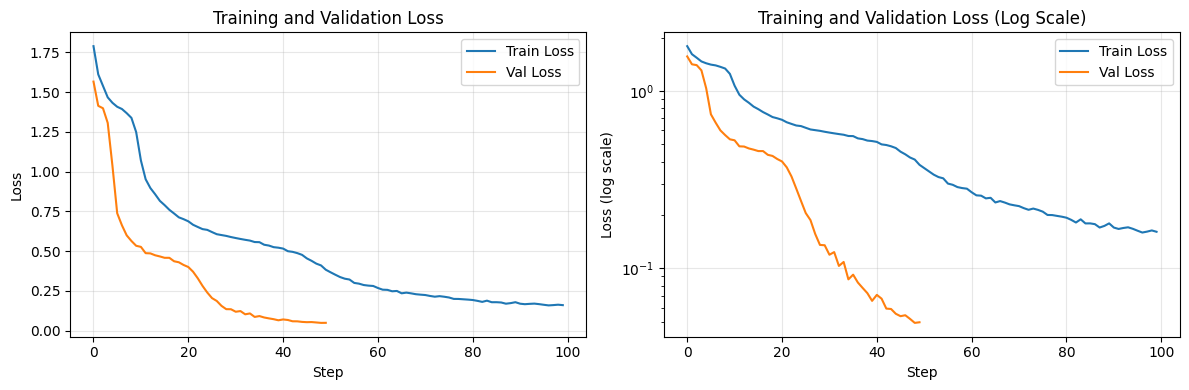

Final train loss: 0.1608
Final val loss: 0.04967975243926048


In [13]:
# Load training logs
import json

# Get training history from trainer
if hasattr(trainer.state, "log_history"):
    logs = trainer.state.log_history

    # Extract loss and eval loss
    train_losses = [
        log["loss"] for log in logs if "loss" in log and "eval_loss" not in log
    ]
    eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]
    steps = [log["step"] for log in logs if "loss" in log or "eval_loss" in log]

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    if train_losses:
        plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    if eval_losses:
        plt.plot(range(len(eval_losses)), eval_losses, label="Val Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    if train_losses:
        plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    if eval_losses:
        plt.plot(range(len(eval_losses)), eval_losses, label="Val Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss (log scale)")
    plt.title("Training and Validation Loss (Log Scale)")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=150)
    plt.show()

    print(f"Final train loss: {train_losses[-1] if train_losses else 'N/A'}")
    print(f"Final val loss: {eval_losses[-1] if eval_losses else 'N/A'}")
else:
    print("No training logs available")


In [14]:
# Load trained model
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(output_dir)
tokenizer = CharTokenizer.from_pretrained(output_dir)
model.eval()

print("Model and tokenizer loaded")


Model and tokenizer loaded


In [33]:
# Evaluation function
def evaluate_dataset(model, tokenizer, dataset, max_new_tokens=10):
    """Evaluate model on a dataset."""
    model.eval()
    exact_correct = 0
    normalized_correct = 0
    total = 0

    def normalize_whitespace(text):
        return "".join(text.split()) if text else ""

    sample_predictions = []

    for i, example in enumerate(dataset):
        prompt = example["prompt"]
        ground_truth = example["completion"]

        # Encode prompt
        input_ids = tokenizer.encode(prompt)
        device = next(model.parameters()).device

        # Generate step-by-step (more reliable than model.generate for this case)
        current_ids = input_ids.copy()
        generated_tokens = []

        with torch.no_grad():
            for step in range(max_new_tokens):
                input_tensor = torch.tensor([current_ids]).to(device)
                logits = model(input_tensor).logits
                next_token_id = logits[0, -1, :].argmax().item()

                # Stop if we hit EOS
                if next_token_id == tokenizer.eos_token_id:
                    break

                generated_tokens.append(next_token_id)
                current_ids.append(next_token_id)

        # Decode the generated tokens
        prediction = tokenizer.decode(generated_tokens).strip()

        # Evaluate
        exact_match = prediction == ground_truth
        normalized_match = normalize_whitespace(prediction) == normalize_whitespace(
            ground_truth
        )

        if exact_match:
            exact_correct += 1
        if normalized_match:
            normalized_correct += 1
        total += 1

        # Store samples
        if len(sample_predictions) < 10:
            sample_predictions.append(
                {
                    "prompt": prompt,
                    "ground_truth": ground_truth,
                    "prediction": prediction,
                    "exact_match": exact_match,
                    "normalized_match": normalized_match,
                }
            )

        if (i + 1) % 1000 == 0:
            print(f"Evaluated {i + 1}/{len(dataset)} examples")

    exact_accuracy = exact_correct / total if total > 0 else 0
    normalized_accuracy = normalized_correct / total if total > 0 else 0

    return {
        "exact_accuracy": exact_accuracy,
        "normalized_accuracy": normalized_accuracy,
        "exact_correct": exact_correct,
        "normalized_correct": normalized_correct,
        "total": total,
        "sample_predictions": sample_predictions,
    }


In [34]:
# Quick test of evaluation function on a single example
print("=== Testing evaluation function ===")
test_ex = test_id_dataset[0]
print(f"Test example: '{test_ex['prompt']}' → '{test_ex['completion']}'")

# Test the generation logic
input_ids = tokenizer.encode(test_ex["prompt"])
device = next(model.parameters()).device
current_ids = input_ids.copy()
generated_tokens = []

model.eval()
with torch.no_grad():
    for step in range(10):
        input_tensor = torch.tensor([current_ids]).to(device)
        logits = model(input_tensor).logits
        next_token_id = logits[0, -1, :].argmax().item()

        print(
            f"Step {step + 1}: Generated token ID {next_token_id} ('{tokenizer._convert_id_to_token(next_token_id)}')"
        )

        if next_token_id == tokenizer.eos_token_id:
            print("Hit EOS, stopping")
            break

        generated_tokens.append(next_token_id)
        current_ids.append(next_token_id)

prediction = tokenizer.decode(generated_tokens).strip()
print(f"\nPrediction: '{prediction}'")
print(f"Expected: '{test_ex['completion']}'")
print(f"Match: {prediction == test_ex['completion']}")


=== Testing evaluation function ===
Test example: '5944 + 3006 =' → '8950'
Step 1: Generated token ID 8 ('8')
Step 2: Generated token ID 9 ('9')
Step 3: Generated token ID 5 ('5')
Step 4: Generated token ID 0 ('0')
Step 5: Generated token ID 11 ('=')
Hit EOS, stopping

Prediction: '8950'
Expected: '8950'
Match: True


In [35]:
# Evaluate on ID test set
print("Evaluating on ID test set...")
id_results = evaluate_dataset(model, tokenizer, test_id_dataset)

print(f"\nID Test Results:")
print(
    f"  Exact match accuracy: {id_results['exact_accuracy']:.4f} ({id_results['exact_correct']}/{id_results['total']})"
)
print(
    f"  Normalized accuracy: {id_results['normalized_accuracy']:.4f} ({id_results['normalized_correct']}/{id_results['total']})"
)

print("\nSample ID predictions:")
for i, sample in enumerate(id_results["sample_predictions"][:5]):
    print(
        f"  {i + 1}. {sample['prompt']} → GT: '{sample['ground_truth']}', Pred: '{sample['prediction']}' "
    )
    print(
        f"     Exact: {sample['exact_match']}, Normalized: {sample['normalized_match']}"
    )


Evaluating on ID test set...
Evaluated 1000/10000 examples
Evaluated 2000/10000 examples
Evaluated 3000/10000 examples
Evaluated 4000/10000 examples
Evaluated 5000/10000 examples
Evaluated 6000/10000 examples
Evaluated 7000/10000 examples
Evaluated 8000/10000 examples
Evaluated 9000/10000 examples
Evaluated 10000/10000 examples

ID Test Results:
  Exact match accuracy: 0.9163 (9163/10000)
  Normalized accuracy: 0.9163 (9163/10000)

Sample ID predictions:
  1. 5944 + 3006 = → GT: '8950', Pred: '8950' 
     Exact: True, Normalized: True
  2. 3852 + 1310 = → GT: '5162', Pred: '5162' 
     Exact: True, Normalized: True
  3. 3952 + 3207 = → GT: '7159', Pred: '7169' 
     Exact: False, Normalized: False
  4. 1699 + 8984 = → GT: '10683', Pred: '10683' 
     Exact: True, Normalized: True
  5. 5861 + 6576 = → GT: '12437', Pred: '12437' 
     Exact: True, Normalized: True


In [36]:
# Generate and evaluate on OOD test set
print("Generating OOD test set...")

# Get exclude pairs from ID splits
all_id_pairs = train_pairs | val_pairs | test_pairs
test_ood_dataset = dataset.generate_ood_data(exclude_pairs=all_id_pairs)

print(f"OOD test size: {len(test_ood_dataset)}")
print("\nSample OOD examples:")
for i in range(3):
    ex = test_ood_dataset[i]
    print(f"  {ex['prompt']} → {ex['completion']}")

print("\nEvaluating on OOD test set...")
ood_results = evaluate_dataset(model, tokenizer, test_ood_dataset)

print(f"\nOOD Test Results:")
print(
    f"  Exact match accuracy: {ood_results['exact_accuracy']:.4f} ({ood_results['exact_correct']}/{ood_results['total']})"
)
print(
    f"  Normalized accuracy: {ood_results['normalized_accuracy']:.4f} ({ood_results['normalized_correct']}/{ood_results['total']})"
)

print("\nSample OOD predictions:")
for i, sample in enumerate(ood_results["sample_predictions"][:5]):
    print(
        f"  {i + 1}. {sample['prompt']} → GT: '{sample['ground_truth']}', Pred: '{sample['prediction']}' "
    )
    print(
        f"     Exact: {sample['exact_match']}, Normalized: {sample['normalized_match']}"
    )


Generating OOD test set...
OOD test size: 10000

Sample OOD examples:
  8 028 + 2 624= → 10652
  7 448 + 6 783= → 14231
  2 031 + 8 666= → 10697

Evaluating on OOD test set...
Evaluated 1000/10000 examples
Evaluated 2000/10000 examples
Evaluated 3000/10000 examples
Evaluated 4000/10000 examples
Evaluated 5000/10000 examples
Evaluated 6000/10000 examples
Evaluated 7000/10000 examples
Evaluated 8000/10000 examples
Evaluated 9000/10000 examples
Evaluated 10000/10000 examples

OOD Test Results:
  Exact match accuracy: 0.0000 (0/10000)
  Normalized accuracy: 0.0000 (0/10000)

Sample OOD predictions:
  1. 8 028 + 2 624= → GT: '10652', Pred: '138' 
     Exact: False, Normalized: False
  2. 7 448 + 6 783= → GT: '14231', Pred: '591' 
     Exact: False, Normalized: False
  3. 2 031 + 8 666= → GT: '10697', Pred: '969' 
     Exact: False, Normalized: False
  4. 3 715 + 9 760= → GT: '13475', Pred: '898' 
     Exact: False, Normalized: False
  5. 8 167 + 3 135= → GT: '11302', Pred: '187' 
     Exact

In [40]:
# Debug OOD examples
print("=== Debugging OOD Examples ===")
ood_example = test_ood_dataset[0]
print(f"OOD Example: '{ood_example['prompt']}' → Expected: '{ood_example['completion']}'")

# Encode and see what tokens we get
input_ids = tokenizer.encode(ood_example['prompt'])
print(f"Encoded OOD prompt: {input_ids}")
print(f"Decoded back: '{tokenizer.decode(input_ids)}'")

# Compare with ID format
id_example = test_id_dataset[0]
print(f"\nID Example for comparison: '{id_example['prompt']}' → Expected: '{id_example['completion']}'")
id_input_ids = tokenizer.encode(id_example['prompt'])
print(f"Encoded ID prompt: {id_input_ids}")
print(f"Decoded back: '{tokenizer.decode(id_input_ids)}'")

# Generate on OOD example step by step
print("\n=== Generating on OOD example ===")
device = next(model.parameters()).device
current_ids = input_ids.copy()
generated_tokens = []

model.eval()
with torch.no_grad():
    for step in range(10):
        input_tensor = torch.tensor([current_ids]).to(device)
        logits = model(input_tensor).logits
        next_token_id = logits[0, -1, :].argmax().item()
        next_token = tokenizer._convert_id_to_token(next_token_id)

        print(f"Step {step+1}: Generated '{next_token}' (ID {next_token_id})")

        if next_token_id == tokenizer.eos_token_id:
            print("Hit EOS, stopping")
            break

        generated_tokens.append(next_token_id)
        current_ids.append(next_token_id)

prediction = tokenizer.decode(generated_tokens).strip()
print(f"\nPrediction: '{prediction}'")
print(f"Expected: '{ood_example['completion']}'")

=== Debugging OOD Examples ===
OOD Example: '8 028 + 2 624=' → Expected: '10652'
Encoded OOD prompt: [8, 12, 0, 2, 8, 12, 10, 12, 2, 12, 6, 2, 4, 11]
Decoded back: '8 028 + 2 624='

ID Example for comparison: '5944 + 3006 =' → Expected: '8950'
Encoded ID prompt: [5, 9, 4, 4, 12, 10, 12, 3, 0, 0, 6, 12, 11]
Decoded back: '5944 + 3006 ='

=== Generating on OOD example ===
Step 1: Generated '1' (ID 1)
Step 2: Generated '3' (ID 3)
Step 3: Generated '8' (ID 8)
Step 4: Generated '=' (ID 11)
Hit EOS, stopping

Prediction: '138'
Expected: '10652'


In [37]:
# Save results
results = {
    "id_test": {
        "exact": id_results["exact_accuracy"],
        "normalized": id_results["normalized_accuracy"],
        "exact_correct": id_results["exact_correct"],
        "normalized_correct": id_results["normalized_correct"],
        "total": id_results["total"],
    },
    "ood_test": {
        "exact": ood_results["exact_accuracy"],
        "normalized": ood_results["normalized_accuracy"],
        "exact_correct": ood_results["exact_correct"],
        "normalized_correct": ood_results["normalized_correct"],
        "total": ood_results["total"],
    },
}

with open("results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Results saved to results.json")


Results saved to results.json


In [38]:
# Download checkpoints and results
import shutil
import zipfile
from google.colab import files

print("Creating archive of checkpoints and results...")

# Create a zip file with all important outputs
zip_path = "addition_task_outputs.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add checkpoints directory
    if os.path.exists(output_dir):
        for root, dirs, filenames in os.walk(output_dir):
            for filename in filenames:
                file_path = os.path.join(root, filename)
                arcname = os.path.relpath(file_path, '.')
                zipf.write(file_path, arcname)
                print(f"Added: {arcname}")

    # Add results.json if it exists
    if os.path.exists('results.json'):
        zipf.write('results.json', 'results.json')
        print("Added: results.json")

    # Add training details if saved
    if 'training_details' in locals():
        import json
        with open('training_details.json', 'w') as f:
            json.dump(training_details, f, indent=2)
        zipf.write('training_details.json', 'training_details.json')
        print("Added: training_details.json")

print(f"\nArchive created: {zip_path}")
print("Downloading...")
files.download(zip_path)
print("Download complete!")

Creating archive of checkpoints and results...
Added: checkpoints/model.safetensors
Added: checkpoints/config.json
Added: checkpoints/special_tokens_map.json
Added: checkpoints/tokenizer_config.json
Added: checkpoints/generation_config.json
Added: checkpoints/training_args.bin
Added: checkpoints/vocab.txt
Added: checkpoints/README.md
Added: checkpoints/checkpoint-7644/model.safetensors
Added: checkpoints/checkpoint-7644/scheduler.pt
Added: checkpoints/checkpoint-7644/trainer_state.json
Added: checkpoints/checkpoint-7644/rng_state.pth
Added: checkpoints/checkpoint-7644/config.json
Added: checkpoints/checkpoint-7644/special_tokens_map.json
Added: checkpoints/checkpoint-7644/tokenizer_config.json
Added: checkpoints/checkpoint-7644/optimizer.pt
Added: checkpoints/checkpoint-7644/generation_config.json
Added: checkpoints/checkpoint-7644/training_args.bin
Added: checkpoints/checkpoint-7644/vocab.txt
Added: checkpoints/checkpoint-7820/model.safetensors
Added: checkpoints/checkpoint-7820/sched

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete!


## 7. Results Visualization and Tables


In [41]:
# Create results table
import pandas as pd

results_table = pd.DataFrame(
    {
        "Test Set": ["ID Test", "OOD Test"],
        "Exact Match": [results["id_test"]["exact"], results["ood_test"]["exact"]],
        "Normalized Match": [
            results["id_test"]["normalized"],
            results["ood_test"]["normalized"],
        ],
    }
)

print("Results Summary:")
print(results_table.to_string(index=False))

# Save as CSV
results_table.to_csv("results_table.csv", index=False)


Results Summary:
Test Set  Exact Match  Normalized Match
 ID Test       0.9163            0.9163
OOD Test       0.0000            0.0000


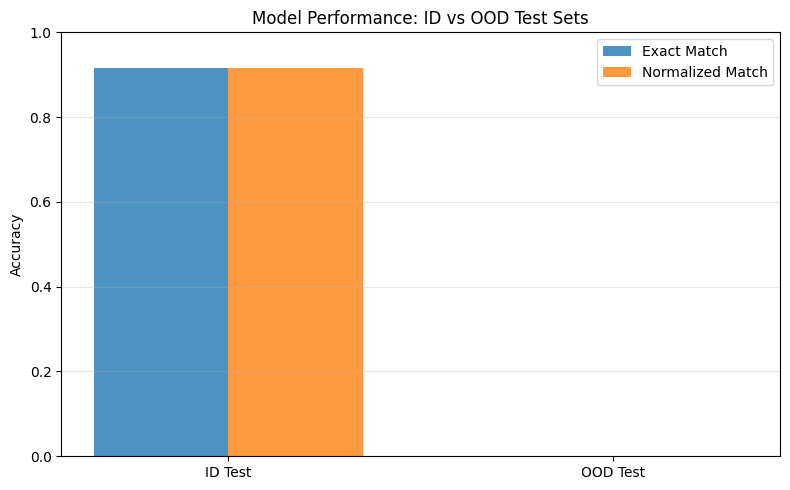

In [42]:
# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(8, 5))

x = ["ID Test", "OOD Test"]
exact_accs = [results["id_test"]["exact"], results["ood_test"]["exact"]]
norm_accs = [results["id_test"]["normalized"], results["ood_test"]["normalized"]]

x_pos = np.arange(len(x))
width = 0.35

ax.bar(x_pos - width / 2, exact_accs, width, label="Exact Match", alpha=0.8)
ax.bar(x_pos + width / 2, norm_accs, width, label="Normalized Match", alpha=0.8)

ax.set_ylabel("Accuracy")
ax.set_title("Model Performance: ID vs OOD Test Sets")
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=150)
plt.show()


## 8. Report Summary Generation


In [43]:
# Compile all information for report
report_data = {
    "task_setup": task_setup,
    "data_diagnostics": data_diagnostics,
    "training_details": training_details,
    "results": results,
}

# Save to JSON
with open("report_data.json", "w") as f:
    json.dump(report_data, f, indent=2)

print("Report data saved to report_data.json")

# Print summary for easy copy-paste
print("\n" + "=" * 60)
print("REPORT SUMMARY")
print("=" * 60)

print("\n1. Task Setup:")
print(f"   Format: {task_setup['input_format']} → {task_setup['output_format']}")
print(f"   k: {task_setup['k']}")
print(f"   Model: {task_setup['model_architecture']}")
print(
    f"   Tokenizer: {task_setup['tokenizer']['type']} ({task_setup['tokenizer']['vocab_size']} tokens)"
)

print("\n2. Data Design:")
print(f"   Train: {data_diagnostics['train_size']}")
print(f"   Val: {data_diagnostics['val_size']}")
print(f"   Test ID: {data_diagnostics['test_id_size']}")
print(
    f"   Overlaps: {data_diagnostics['overlap_train_val']}, {data_diagnostics['overlap_train_test']}, {data_diagnostics['overlap_val_test']}"
)

print("\n3. Training Details:")
print(f"   Batch size: {training_config['batch_size']}")
print(f"   Learning rate: {training_config['learning_rate']}")
print(f"   Epochs: {training_config['num_epochs']}")
print(f"   Training time: {training_details['training_time_minutes']:.2f} minutes")
if gpu_info:
    print(f"   GPU: {gpu_info['device']}")

print("\n4. Results:")
print(
    f"   ID Test - Exact: {results['id_test']['exact']:.4f}, Normalized: {results['id_test']['normalized']:.4f}"
)
print(
    f"   OOD Test - Exact: {results['ood_test']['exact']:.4f}, Normalized: {results['ood_test']['normalized']:.4f}"
)

print("\n" + "=" * 60)


Report data saved to report_data.json

REPORT SUMMARY

1. Task Setup:
   Format: 1234 + 5678 = → 6912
   k: 4
   Model: {'num_layers': 4, 'hidden_size': 128, 'num_attention_heads': 4, 'intermediate_size': 512, 'vocab_size': 13}
   Tokenizer: character-level (13 tokens)

2. Data Design:
   Train: 50000
   Val: 10000
   Test ID: 10000
   Overlaps: 0, 0, 0

3. Training Details:
   Batch size: 64
   Learning rate: 0.0005
   Epochs: 10
   Training time: 9.09 minutes
   GPU: Tesla T4

4. Results:
   ID Test - Exact: 0.9163, Normalized: 0.9163
   OOD Test - Exact: 0.0000, Normalized: 0.0000

